In [10]:
from ultralytics import YOLO
import cv2
import numpy as np
import matplotlib.pyplot as plt

model = YOLO("yolov8n.pt")

In [30]:
from ultralytics import YOLO
import cv2

model = YOLO("yolov8n.pt")

def count_unique_bikes(video_path):
    cap = cv2.VideoCapture(video_path)

    unique_ids = set()   # hier speichern wir jedes neue Velo
    frame_idx = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        results = model.track(frame, persist=True, verbose=False)

        if results[0].boxes is not None:
            boxes = results[0].boxes
            clses = boxes.cls.cpu().numpy()
            ids = boxes.id.cpu().numpy() if boxes.id is not None else []

            for cls, track_id in zip(clses, ids):
                # Fahrrad in COCO = Klasse 1
                if int(cls) == 1:
                    unique_ids.add(int(track_id))

        frame_idx += 1

    cap.release()
    return unique_ids

unique_velos = count_unique_bikes("data/velopark2.mp4")
print("Total verschiedene Velos im Video:", len(unique_velos))


Total verschiedene Velos im Video: 119


=== Details für Frame 120 ===
Objekt 0: bicycle (cls=1), conf=0.52, bbox=[544, 765, 1079, 1355], Breite=536, Höhe=591, Fläche=316389
Objekt 1: motorcycle (cls=3), conf=0.27, bbox=[371, 458, 882, 888], Breite=510, Höhe=430, Fläche=219543
Objekt 2: car (cls=2), conf=0.26, bbox=[836, 396, 1080, 569], Breite=243, Höhe=172, Fläche=41899


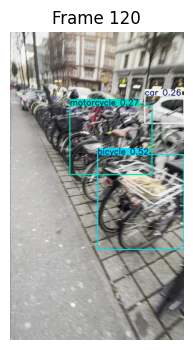

In [31]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt

model = YOLO("yolov8n.pt")
CLASS_NAMES = model.names  # dict: {0: 'person', 1: 'bicycle', ...}

def inspect_single_frame(video_path, frame_idx_to_show=100):
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx_to_show)

    ret, frame = cap.read()
    if not ret:
        print(f"Frame {frame_idx_to_show} konnte nicht gelesen werden.")
        cap.release()
        return

    results = model.predict(frame, verbose=False)
    boxes = results[0].boxes

    print(f"=== Details für Frame {frame_idx_to_show} ===")
    if boxes is None or len(boxes) == 0:
        print("Keine Objekte erkannt.")
    else:
        for i in range(len(boxes)):
            cls_id = int(boxes.cls[i].item())
            conf = float(boxes.conf[i].item())
            x1, y1, x2, y2 = boxes.xyxy[i].tolist()
            w = x2 - x1
            h = y2 - y1
            area = w * h

            print(
                f"Objekt {i}: {CLASS_NAMES[cls_id]} "
                f"(cls={cls_id}), conf={conf:.2f}, "
                f"bbox=[{x1:.0f}, {y1:.0f}, {x2:.0f}, {y2:.0f}], "
                f"Breite={w:.0f}, Höhe={h:.0f}, Fläche={area:.0f}"
            )

    # Bild mit Bounding Boxes anzeigen
    plotted = results[0].plot()   # OpenCV-Image mit Boxen
    plt.figure(figsize=(6,4))
    plt.imshow(plotted[:, :, ::-1])
    plt.title(f"Frame {frame_idx_to_show}")
    plt.axis("off")
    plt.show()

    cap.release()

# Beispielaufruf:
inspect_single_frame("data/velopark1.mp4", frame_idx_to_show=120)


In [33]:
import pandas as pd
from pathlib import Path

model = YOLO("yolov8n.pt")
CLASS_NAMES = model.names  # dict

def extract_detections(video_path, max_frames=None):
    """
    Lädt ein Video und schreibt JEDE YOLO-Detection in ein DataFrame.
    Spalten u.a.: Frame, Klasse, Klassenname, Konfidenz, Bounding Box, Fläche.
    """
    video_path = Path(video_path)
    if not video_path.exists():
        raise FileNotFoundError(video_path)

    cap = cv2.VideoCapture(str(video_path))

    records = []
    frame_idx = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        if max_frames is not None and frame_idx >= max_frames:
            break

        results = model.predict(frame, verbose=False)
        boxes = results[0].boxes

        if boxes is not None and len(boxes) > 0:
            for i in range(len(boxes)):
                cls_id = int(boxes.cls[i].item())
                conf = float(boxes.conf[i].item())
                x1, y1, x2, y2 = boxes.xyxy[i].tolist()
                w = x2 - x1
                h = y2 - y1
                area = w * h

                records.append({
                    "frame": frame_idx,
                    "cls_id": cls_id,
                    "cls_name": CLASS_NAMES[cls_id],
                    "conf": conf,
                    "x1": x1, "y1": y1, "x2": x2, "y2": y2,
                    "width": w, "height": h,
                    "area": area,
                    "is_bike": (cls_id == 1),   # Fahrrad-Flag
                })

        frame_idx += 1

    cap.release()
    df = pd.DataFrame(records)
    return df

# Aufruf:
df_det = extract_detections("data/velopark2.mp4")
print(df_det.head())
print("Anzahl Detections insgesamt:", len(df_det))


   frame  cls_id cls_name      conf           x1           y1           x2  \
0      1       0   person  0.465543   940.523987   667.677429  1020.133484   
1      1       0   person  0.318010   882.385986   667.571411   949.519775   
2      2       0   person  0.392317   940.370911   659.734131  1013.899109   
3      4       6    train  0.350769     1.173340    59.739716  1080.000000   
4      5       1  bicycle  0.346989  1014.229248  1075.780151  1080.000000   

            y2        width       height          area  is_bike  
0   836.728821    79.609497   169.051392  1.345810e+04    False  
1   845.006714    67.133789   177.435303  1.191190e+04    False  
2   829.305176    73.528198   169.571045  1.246825e+04    False  
3  1450.231934  1078.826660  1390.492218  1.500100e+06    False  
4  1307.329468    65.770752   231.549316  1.522917e+04     True  
Anzahl Detections insgesamt: 3063


In [34]:
# Nur Bikes
df_bikes = df_det[df_det["is_bike"]]

# Konfidenz-Stats
print(df_bikes["conf"].describe())

# Wie viele Bikes pro Frame?
bike_counts_per_frame = df_bikes.groupby("frame")["cls_id"].count()

# Verteilung anderer Klassen
print(df_det["cls_name"].value_counts().head(10))

# Durchschnittliche Boxfläche der Bikes (wie groß sind die Velos im Bild?)
print(df_bikes["area"].describe())

count    2356.000000
mean        0.387900
std         0.124053
min         0.250063
25%         0.292787
50%         0.350625
75%         0.447121
max         0.878848
Name: conf, dtype: float64
cls_name
bicycle        2356
motorcycle      594
person           58
banana           21
car              18
bus               8
bottle            4
train             1
bench             1
sports ball       1
Name: count, dtype: int64
count    2.356000e+03
mean     2.124152e+05
std      1.091031e+05
min      1.522917e+04
25%      1.346319e+05
50%      1.928220e+05
75%      2.659315e+05
max      1.122584e+06
Name: area, dtype: float64


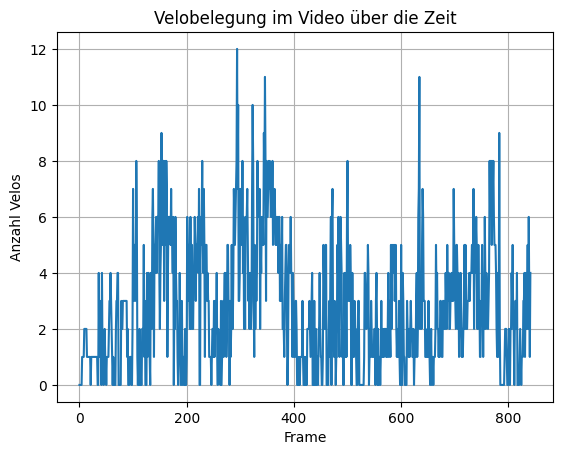

In [35]:
bike_counts_series = df_bikes.groupby("frame")["cls_id"].count()
bike_counts = bike_counts_series.reindex(range(bike_counts_series.index.max()+1), fill_value=0)

bike_counts.plot()
plt.xlabel("Frame")
plt.ylabel("Anzahl Velos")
plt.title("Velobelegung im Video über die Zeit")
plt.grid(True)
plt.show()


# Visualisierungen

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Wir gehen davon aus, dass df_det bereits existiert
# Falls nicht: vorher extract_detections() ausführen

df_bikes = df_det[df_det["cls_id"] == 1].copy()

print("Anzahl erkannter Bikes:", len(df_bikes))
df_bikes.head()


Anzahl erkannter Bikes: 2356


,frame,cls_id,cls_name,conf,x1,y1,x2,y2,width,height,area,is_bike
4,5,1,bicycle,0.346989,1014.229248,1075.780151,1080.0,1307.329468,65.770752,231.549316,15229.172654,True
5,6,1,bicycle,0.406119,989.591736,1054.528442,1080.0,1323.291748,90.408264,268.763306,24298.423935,True
7,7,1,bicycle,0.431665,960.214417,1046.538574,1080.0,1342.114746,119.785583,295.576172,35405.764216,True
9,8,1,bicycle,0.621776,935.975464,1045.464478,1080.0,1348.191650,144.024536,302.727173,43600.140645,True
11,9,1,bicycle,0.600819,912.670715,1020.164246,1080.0,1357.153687,167.329285,336.989441,56388.202089,True


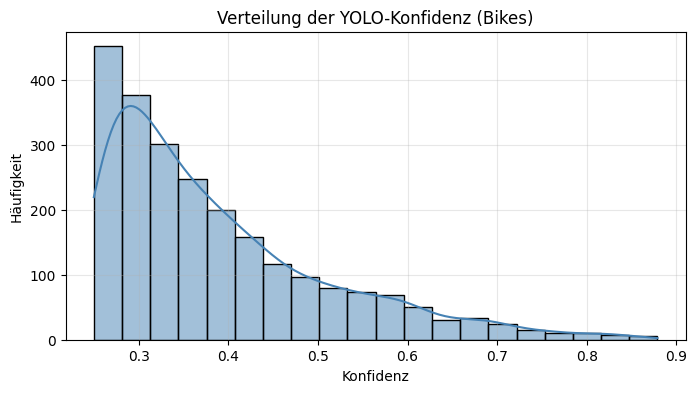

In [37]:
plt.figure(figsize=(8,4))
sns.histplot(df_bikes["conf"], bins=20, kde=True, color="steelblue")
plt.title("Verteilung der YOLO-Konfidenz (Bikes)")
plt.xlabel("Konfidenz")
plt.ylabel("Häufigkeit")
plt.grid(True, alpha=0.3)
plt.show()

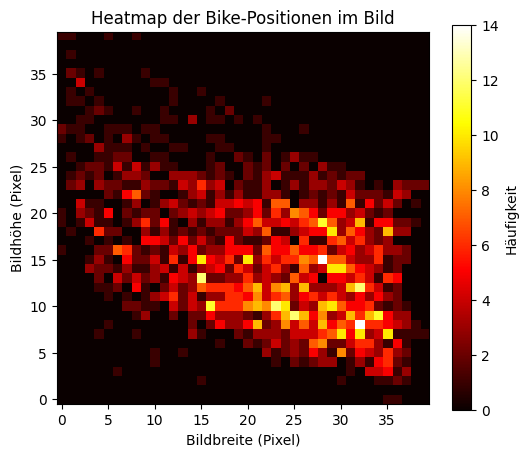

In [38]:
df_bikes["cx"] = (df_bikes["x1"] + df_bikes["x2"]) / 2
df_bikes["cy"] = (df_bikes["y1"] + df_bikes["y2"]) / 2

# Heatmap Raster
heatmap, xedges, yedges = np.histogram2d(
    df_bikes["cx"],
    df_bikes["cy"],
    bins=40
)

plt.figure(figsize=(6,5))
plt.imshow(
    heatmap.T,
    origin='lower',
    cmap='hot',
    interpolation='nearest'
)
plt.title("Heatmap der Bike-Positionen im Bild")
plt.xlabel("Bildbreite (Pixel)")
plt.ylabel("Bildhöhe (Pixel)")
plt.colorbar(label="Häufigkeit")
plt.show()

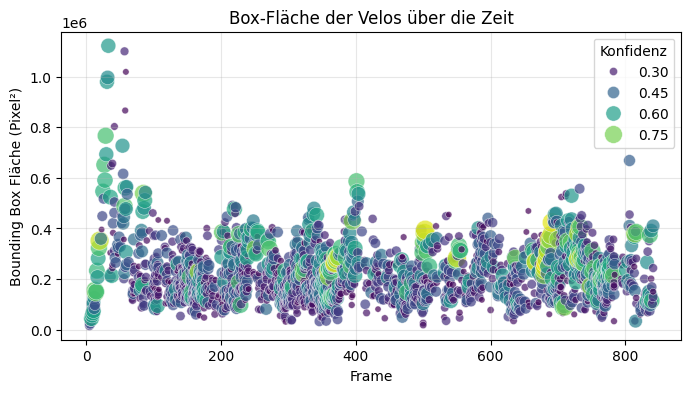

In [39]:
plt.figure(figsize=(8,4))
sns.scatterplot(
    x=df_bikes["frame"],
    y=df_bikes["area"],
    hue=df_bikes["conf"],
    palette="viridis",
    size=df_bikes["conf"],
    sizes=(20,200),
    alpha=0.7
)
plt.title("Box-Fläche der Velos über die Zeit")
plt.xlabel("Frame")
plt.ylabel("Bounding Box Fläche (Pixel²)")
plt.legend(title="Konfidenz", bbox_to_anchor=(1,1))
plt.grid(True, alpha=0.3)
plt.show()


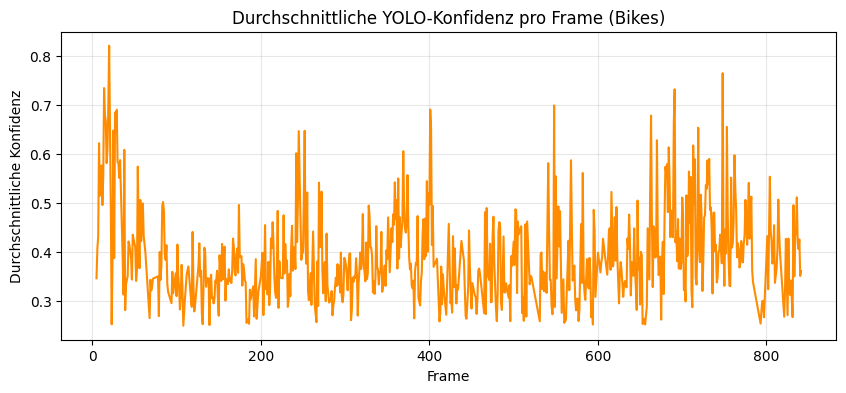

In [40]:
conf_by_frame = df_bikes.groupby("frame")["conf"].mean()

plt.figure(figsize=(10,4))
plt.plot(conf_by_frame.index, conf_by_frame.values, color="darkorange", linewidth=1.5)
plt.title("Durchschnittliche YOLO-Konfidenz pro Frame (Bikes)")
plt.xlabel("Frame")
plt.ylabel("Durchschnittliche Konfidenz")
plt.grid(True, alpha=0.3)
plt.show()

Frames mit maximaler Velobelegung: [171, 196]


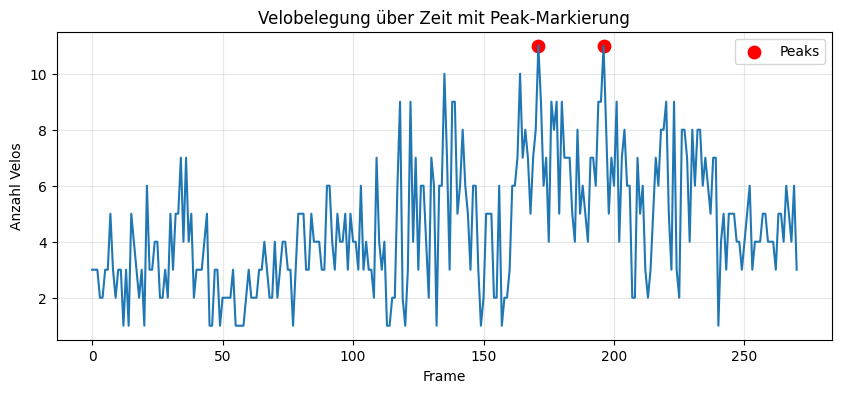

In [28]:
bike_counts = df_bikes.groupby("frame")["cls_id"].count()

peak_frames = bike_counts[bike_counts == bike_counts.max()].index.tolist()
print("Frames mit maximaler Velobelegung:", peak_frames)

plt.figure(figsize=(10,4))
plt.plot(bike_counts.index, bike_counts.values, linewidth=1.5)
plt.scatter(peak_frames, [bike_counts.max()] * len(peak_frames), color="red", s=80, label="Peaks")
plt.title("Velobelegung über Zeit mit Peak-Markierung")
plt.xlabel("Frame")
plt.ylabel("Anzahl Velos")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [42]:
from ultralytics import YOLO
import cv2
from pathlib import Path

model = YOLO("yolov8n.pt")
CLASS_NAMES = model.names

def create_annotated_bike_video(input_path, output_path="data/velopark1_annotated.mp4"):
    input_path = Path(input_path)
    if not input_path.exists():
        raise FileNotFoundError(input_path)

    cap = cv2.VideoCapture(str(input_path))

    fps = cap.get(cv2.CAP_PROP_FPS)
    width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    out = cv2.VideoWriter(str(output_path), fourcc, fps, (width, height))

    frame_idx = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        results = model.predict(frame, verbose=False)
        boxes = results[0].boxes

        if boxes is not None and len(boxes) > 0:
            clses = boxes.cls.cpu().numpy().astype(int)
            confs = boxes.conf.cpu().numpy()
            xyxy = boxes.xyxy.cpu().numpy()

            for cls_id, conf, (x1, y1, x2, y2) in zip(clses, confs, xyxy):
                if cls_id == 1:  # bicycle
                    x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])
                    label = f"bike {conf:.2f}"
                    cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
                    cv2.putText(
                        frame,
                        label,
                        (x1, max(y1 - 5, 15)),
                        cv2.FONT_HERSHEY_SIMPLEX,
                        0.5,
                        (0, 255, 0),
                        1,
                        cv2.LINE_AA,
                    )

        # Frame-Index oben links einblenden
        cv2.putText(
            frame,
            f"Frame {frame_idx}",
            (10, 25),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.7,
            (0, 255, 255),
            2,
            cv2.LINE_AA,
        )

        out.write(frame)
        frame_idx += 1

    cap.release()
    out.release()
    print(f"Fertiges Video gespeichert unter: {output_path}")

# Beispiel:
create_annotated_bike_video("data/velopark1.mp4", "data/velopark1_bikes_conf.mp4")

Fertiges Video gespeichert unter: data/velopark1_bikes_conf.mp4


=== Details für Frame 120 ===
Objekt 0: bicycle (cls=1), conf=0.43, bbox=[292, 748, 864, 1277], Breite=573, Höhe=529, Fläche=302939
Objekt 1: bicycle (cls=1), conf=0.38, bbox=[569, 688, 1000, 1137], Breite=431, Höhe=449, Fläche=193450
Objekt 2: bicycle (cls=1), conf=0.31, bbox=[216, 788, 729, 1276], Breite=513, Höhe=488, Fläche=250458
Objekt 3: bicycle (cls=1), conf=0.30, bbox=[736, 721, 1080, 1100], Breite=344, Höhe=379, Fläche=130350
Objekt 4: bicycle (cls=1), conf=0.26, bbox=[74, 826, 705, 1507], Breite=631, Höhe=681, Fläche=430227


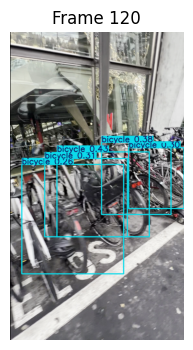

In [43]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt

model = YOLO("yolov8n.pt")
CLASS_NAMES = model.names  # dict: {0: 'person', 1: 'bicycle', ...}

def inspect_single_frame(video_path, frame_idx_to_show=100):
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx_to_show)

    ret, frame = cap.read()
    if not ret:
        print(f"Frame {frame_idx_to_show} konnte nicht gelesen werden.")
        cap.release()
        return

    results = model.predict(frame, verbose=False)
    boxes = results[0].boxes

    print(f"=== Details für Frame {frame_idx_to_show} ===")
    if boxes is None or len(boxes) == 0:
        print("Keine Objekte erkannt.")
    else:
        for i in range(len(boxes)):
            cls_id = int(boxes.cls[i].item())
            conf = float(boxes.conf[i].item())
            x1, y1, x2, y2 = boxes.xyxy[i].tolist()
            w = x2 - x1
            h = y2 - y1
            area = w * h

            print(
                f"Objekt {i}: {CLASS_NAMES[cls_id]} "
                f"(cls={cls_id}), conf={conf:.2f}, "
                f"bbox=[{x1:.0f}, {y1:.0f}, {x2:.0f}, {y2:.0f}], "
                f"Breite={w:.0f}, Höhe={h:.0f}, Fläche={area:.0f}"
            )

    # Bild mit Bounding Boxes anzeigen
    plotted = results[0].plot()   # OpenCV-Image mit Boxen
    plt.figure(figsize=(6,4))
    plt.imshow(plotted[:, :, ::-1])
    plt.title(f"Frame {frame_idx_to_show}")
    plt.axis("off")
    plt.show()

    cap.release()

# Beispielaufruf:
inspect_single_frame("data/velopark2.mp4", frame_idx_to_show=120)


In [44]:
from ultralytics import YOLO
import cv2
from pathlib import Path

model = YOLO("yolov8n.pt")
CLASS_NAMES = model.names

def create_annotated_bike_video(input_path, output_path="data/velopark2_annotated.mp4"):
    input_path = Path(input_path)
    if not input_path.exists():
        raise FileNotFoundError(input_path)

    cap = cv2.VideoCapture(str(input_path))

    fps = cap.get(cv2.CAP_PROP_FPS)
    width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    out = cv2.VideoWriter(str(output_path), fourcc, fps, (width, height))

    frame_idx = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        results = model.predict(frame, verbose=False)
        boxes = results[0].boxes

        if boxes is not None and len(boxes) > 0:
            clses = boxes.cls.cpu().numpy().astype(int)
            confs = boxes.conf.cpu().numpy()
            xyxy = boxes.xyxy.cpu().numpy()

            for cls_id, conf, (x1, y1, x2, y2) in zip(clses, confs, xyxy):
                if cls_id == 1:  # bicycle
                    x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])
                    label = f"bike {conf:.2f}"
                    cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
                    cv2.putText(
                        frame,
                        label,
                        (x1, max(y1 - 5, 15)),
                        cv2.FONT_HERSHEY_SIMPLEX,
                        0.5,
                        (0, 255, 0),
                        1,
                        cv2.LINE_AA,
                    )

        # Frame-Index oben links einblenden
        cv2.putText(
            frame,
            f"Frame {frame_idx}",
            (10, 25),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.7,
            (0, 255, 255),
            2,
            cv2.LINE_AA,
        )

        out.write(frame)
        frame_idx += 1

    cap.release()
    out.release()
    print(f"Fertiges Video gespeichert unter: {output_path}")

# Beispiel:
create_annotated_bike_video("data/velopark2.mp4", "data/velopark2_bikes_conf.mp4")

Fertiges Video gespeichert unter: data/velopark2_bikes_conf.mp4
